# Deep Neural Network for Exoplanet Discovery Method Classification
## Identifying Patterns in Exoplanet Characteristics to Determine Discovery Methods

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

## Data

In [2]:
# data is aleady preprocessed; standardized and one-hot encoded

composite_preprocessed = pd.read_csv('Composite_preprocessed_NO_MV_BALANCED.csv')
composite_preprocessed.head()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year,Detected by Transits
0,3.094076,-0.666894,0.0,2.424559,1.234306,-0.145901,-0.624689,0.613405,1.731519,-0.261600,-0.012466,-0.044364,0,0,2007,0
1,-0.256668,-0.666894,0.0,1.186720,-0.283545,1.148661,-0.992906,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2009,0
2,-0.256668,-0.666894,0.0,-0.877523,-0.306068,0.308947,-2.327878,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2008,0
3,-0.256668,0.216988,0.0,1.382856,-0.669803,0.872499,-0.152934,0.613405,3.735304,0.591749,-0.012466,-0.044364,0,0,2002,0
4,6.444820,-0.666894,0.0,0.261241,-0.531444,1.023143,0.855489,0.613405,3.735304,2.298449,-0.012466,-0.044364,0,0,1996,0


### 2 possible results ; Either the exoplanet was discovered by transits or it wasn't
### so we have 2 output units 
### We will use the features from the XGBoost refined features model 
### This ensures consistency, reduces complexity, and leverages the feature selection process that has already been validated with my refined features XGBoost model
### This would also allow for a fair comparison between models and is likely to result in better performance for the DNN

## Remove unimportant features
### From the logistic regression model, 'Number of Moons' can be excluded because it does not provide value to the model

In [3]:
remove = ['Number of Radial Velocity Time Series',
          'Number of Stellar Spectra Measurements',
          'Controversial Flag',
          'Circumbinary Flag',
          'Number of Moons']

composite_unnecessary_removed = composite_preprocessed.drop(remove, axis=1)

## Train Test Split

In [4]:
# we are trying to predict whether an exoplanet has been detected by transits (0 or 1)

targets = composite_unnecessary_removed['Detected by Transits']

# training features are all variables except the targets

features = composite_unnecessary_removed.drop(['Detected by Transits'], axis=1)

## Observe Feature Correlations

In [5]:
features.corr()

,Number of Stars,Number of Planets,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Discovery Year
Number of Stars,1.000000,0.109074,-0.044988,0.104236,-0.087528,-0.069450,0.057734,-0.003200,-0.002096,-0.147575
Number of Planets,0.109074,1.000000,-0.055511,0.008589,0.026680,-0.023926,-0.002505,0.057797,0.076409,-0.072274
Galactic Latitude [deg],-0.044988,-0.055511,1.000000,-0.019213,0.463063,0.174632,-0.090369,-0.025691,-0.008918,0.031820
Galactic Longitude [deg],0.104236,0.008589,-0.019213,1.000000,-0.657044,-0.408779,0.131333,-0.008283,-0.026088,-0.106558
Ecliptic Latitude [deg],-0.087528,0.026680,0.463063,-0.657044,1.000000,0.498442,-0.222283,-0.006864,0.025212,0.081113
Ecliptic Longitude [deg],-0.069450,-0.023926,0.174632,-0.408779,0.498442,1.000000,-0.119612,0.013811,0.031078,0.058041
Number of Photometry Time Series,0.057734,-0.002505,-0.090369,0.131333,-0.222283,-0.119612,1.000000,-0.004172,-0.014848,-0.252983
Number of Emission Spectroscopy Measurements,-0.003200,0.057797,-0.025691,-0.008283,-0.006864,0.013811,-0.004172,1.000000,-0.000553,0.000791
Number of Transmission Spectroscopy Measurements,-0.002096,0.076409,-0.008918,-0.026088,0.025212,0.031078,-0.014848,-0.000553,1.000000,-0.015425
Discovery Year,-0.147575,-0.072274,0.031820,-0.106558,0.081113,0.058041,-0.252983,0.000791,-0.015425,1.000000


## Split data

In [6]:
# Splitting dataset into training and testing addresses overfitting
# shuffling is necessary to remove dependencies that come from order of data

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, targets, train_size = 0.8, random_state = 42)

x_train.shape, y_train.shape

((5148, 10), (5148,))

## DNN Configuration

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Create Model Container

In [8]:
# Initializes a Sequential Model (linear stack of layers)
# Simplest way to build a model in Keras, where you can just keep adding layers sequentially

dnn_model = Sequential()

### Learn and represent complex relationships in the data

In [9]:
# add dense (fully connected) layer with 64 neurons
# common for hidden layers to start at a high number of neurons to capture complex patterns
# shape[1] specifies our number of input features
# we use Rectified Linear Unit (ReLU) as the activation function because ReLU helps mitigate the vanishing gradient problem
# and allows the model to learn complex paterns

# 64 neurons -> 50% accuracy 
dnn_model.add(Dense(50, input_dim = x_train.shape[1], activation ='relu'))

2024-07-25 22:15:51.307235: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 22:15:51.307632: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


### Measure to prevent overfitting

In [10]:
# add a dropout layer with dropout rate of 0.5 
# This essentially just means 50% of the neurons will be randomly set to 0 during training
# Dropout is a regularization technique used to prevent overfitting 
# This helps prevent the model from overfitting by randomly dropping neurons during training

# dropout 0.5 -> 50 accuracy
dnn_model.add(Dropout(0.4))

### Add another dense layer (this time of 32 neurons) to learn more complex patterns

In [11]:
# Deeper networks (more layers) often capture more complex relationships 
# use relu again to introduce non-linearity

# add 32 - > 50% acc 
dnn_model.add(Dense(50, activation='relu'))

### Add another dropout layer for the same reasoning as before

In [12]:
# Continues to prevent overfitting as the model gets deeper

# changed from 0.5 (50% acc) 
dnn_model.add(Dropout(0.4))

### Add ouput layer of 1 neuron

In [13]:
# 1 neuron because this is a binary classification problem
# We use sigmoid activation for binary classifications
# sigmoid squashes output between 0 and 1, and can be interpreted as a probability 

# 50% accuracy setup : 
dnn_model.add(Dense(1, activation='sigmoid'))

### Compile Model

In [14]:
# Compiling configures the model for the actual training
# we use binary cross-entropy loss because this is great for binary classification problems as it measures performance of a classification
# model where the output is a probability between 0 and 1 
# Adam optimizer is best in practice and works for a wide range of problems
# Starting learning rate of 0.001 is a common starting point 
# we use accuracy as the metric to evaluate performance during training and validation

# lr: 0.001 -> 50% 

dnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

## Training with Validation Split

### Here we train the model while also validating it on a portion of the data to monitor performance and prevent overfitting

In [15]:
# start with 50 epochs (number of times the entire training dataset is passed through the model) bc this is a good starting point
# 50 ensures sufficient training
# batch size 32 means there is 32 samples per gradient update
# 32 for the batch size is a common choice to provide a balance between speed and stability
# we use 20% of the training data for our validation to monitor performance on unseen data during training
# verbose =1 to display progress bar 

# tensorflow models expect data in the form of a np array; NOT a pd dataframe 
# so we have to convert

x_train_nparr, x_test_nparr, y_train_nparr, y_test_nparr = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

# now we train
history = dnn_model.fit(x_train_nparr, y_train_nparr, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Train on 4118 samples, validate on 1030 samples
Epoch 1/5
4118/4118 [==============================] - 2s 448us/sample - loss: 81.7931 - accuracy: 0.5051 - val_loss: 0.7376 - val_accuracy: 0.4845
Epoch 2/5
4118/4118 [==============================] - 0s 100us/sample - loss: 32.0964 - accuracy: 0.4951 - val_loss: 3.5186 - val_accuracy: 0.5097
Epoch 3/5
4118/4118 [==============================] - 0s 100us/sample - loss: 13.6135 - accuracy: 0.5075 - val_loss: 0.6995 - val_accuracy: 0.4903
Epoch 4/5
4118/4118 [==============================] - 0s 108us/sample - loss: 5.2068 - accuracy: 0.4971 - val_loss: 0.6961 - val_accuracy: 0.4903
Epoch 5/5
4118/4118 [==============================] - 0s 106us/sample - loss: 2.4291 - accuracy: 0.4973 - val_loss: 0.6989 - val_accuracy: 0.5097


## Model Predictions

In [16]:
# Here we actually make the predictions on the test set
# model outputs the probability for the positive class
# also convert the probabilities to binary class predictions with a threshold of 0.5

y_pred_prob = dnn_model.predict(x_test_nparr)

## Raw probabilities for the positive class

In [17]:
# We use these probabilities for calculating the ROC-AUC score and other performance metrics that require probabilities
# ravel() flattens the matrix to a 1D array of probabilities

y_pred = (y_pred_prob > 0.5).astype("int32")

## Evaluate Model performance

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [19]:
('DNN Accuracy on Test Set:', accuracy_score(y_test_nparr, y_pred))
('DNN Classification Report on Test Set:\n', classification_report(y_test_nparr, y_pred))
('DNN ROC AUC Score on Test Set:', roc_auc_score(y_test_nparr, y_pred_prob))

/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

('DNN ROC AUC Score on Test Set:', 0.7328780501920725)

## Plot Validation and Training Metrics for visual presentation 

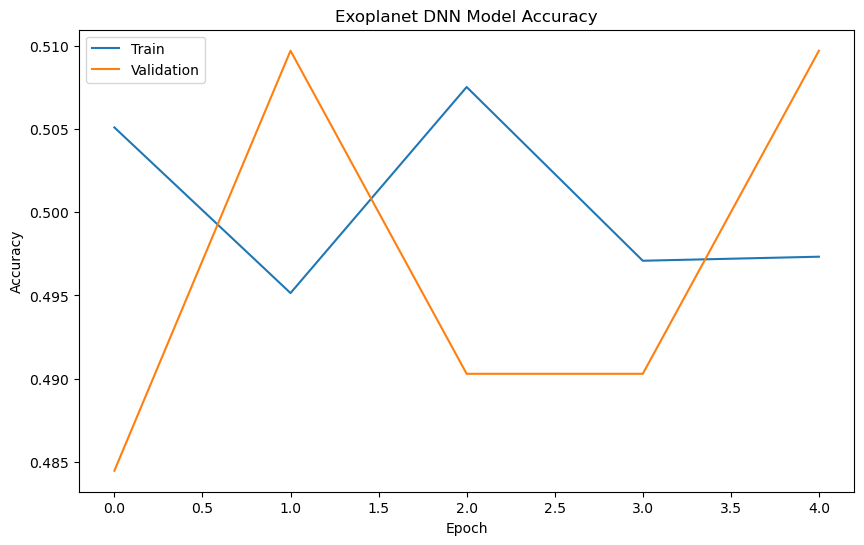

In [20]:
plt.figure(figsize=(10,6))

# training accuracy over epochs
plt.plot(history.history['accuracy'])

# validation accuracy over epochs
plt.plot(history.history['val_accuracy'])

plt.title('Exoplanet DNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

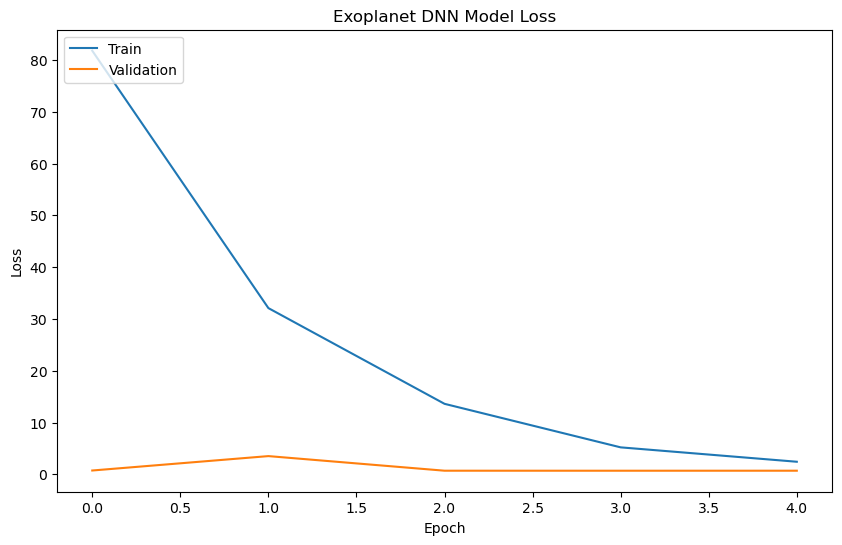

In [21]:
# Display loss separately 
# Loss is a fundamental measure of how well a machine learning model's predictions match the actual outcomes
# Loss quantifies the difference between pred values and actual values 
# Goal of training a model is to MINIMIZE LOSS
# By minimizing loss we can improve the model's accuracy and predictive power
# Loss guides hyperparamter tuning

plt.figure(figsize=(10,6))

# training loss over epochs
plt.plot(history.history['loss'])

# validation loss over epochs
plt.plot(history.history['val_loss'])

plt.title('Exoplanet DNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()